In [37]:
import time
import math
import decimal
from pandas import DataFrame
from decimal import Decimal as dec
import seaborn as sns
import numpy as np
from numpy import random as np_rnd
import scipy
from scipy.stats.distributions import norm
import random as rnd
from vpython import vector
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from IPython.display import Latex

%matplotlib notebook

### Setup
At first, generate some random values

In [108]:
EPSILON = 1e-3
SECTION = 360
GRADIENT_STEP = 1000 * EPSILON
I = 109

alpha, beta = rnd.uniform(0, 1), rnd.uniform(0, 1)

X = [k / 100 for k in range(0, 101)]
delta = norm(loc=0, scale=1).rvs(size=101)
Y = [alpha * x_k + beta + delta_k for x_k, delta_k in zip(X, delta)]

Then visualize the generated noise

<IPython.core.display.Javascript object>


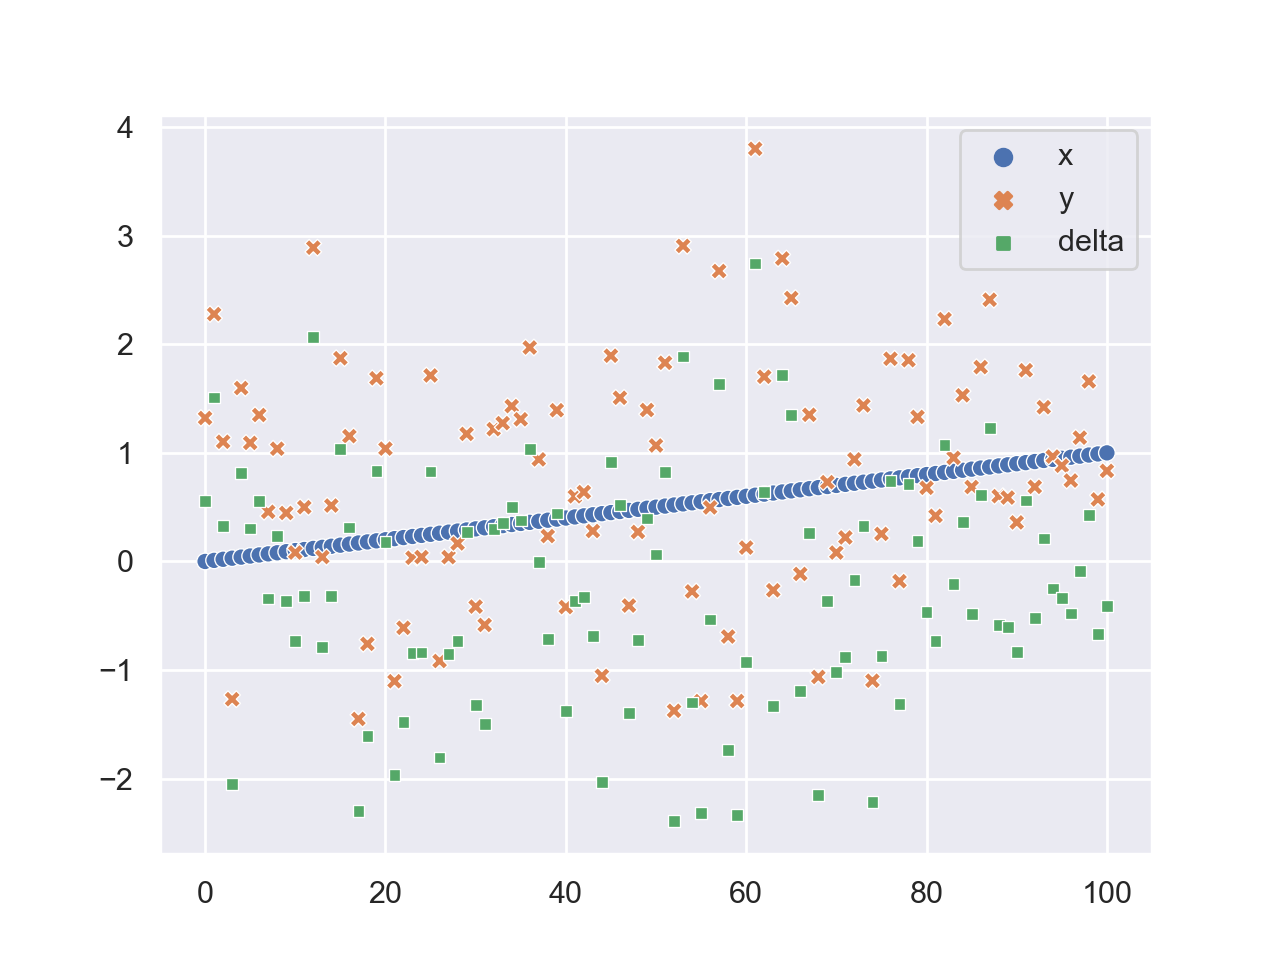

<AxesSubplot:>

In [4]:
noise = DataFrame({"x":X,"y":Y,"delta":delta})
sns.set_theme()
sns.scatterplot(data=noise)

Distribution of the noise is close to normal

<IPython.core.display.Javascript object>


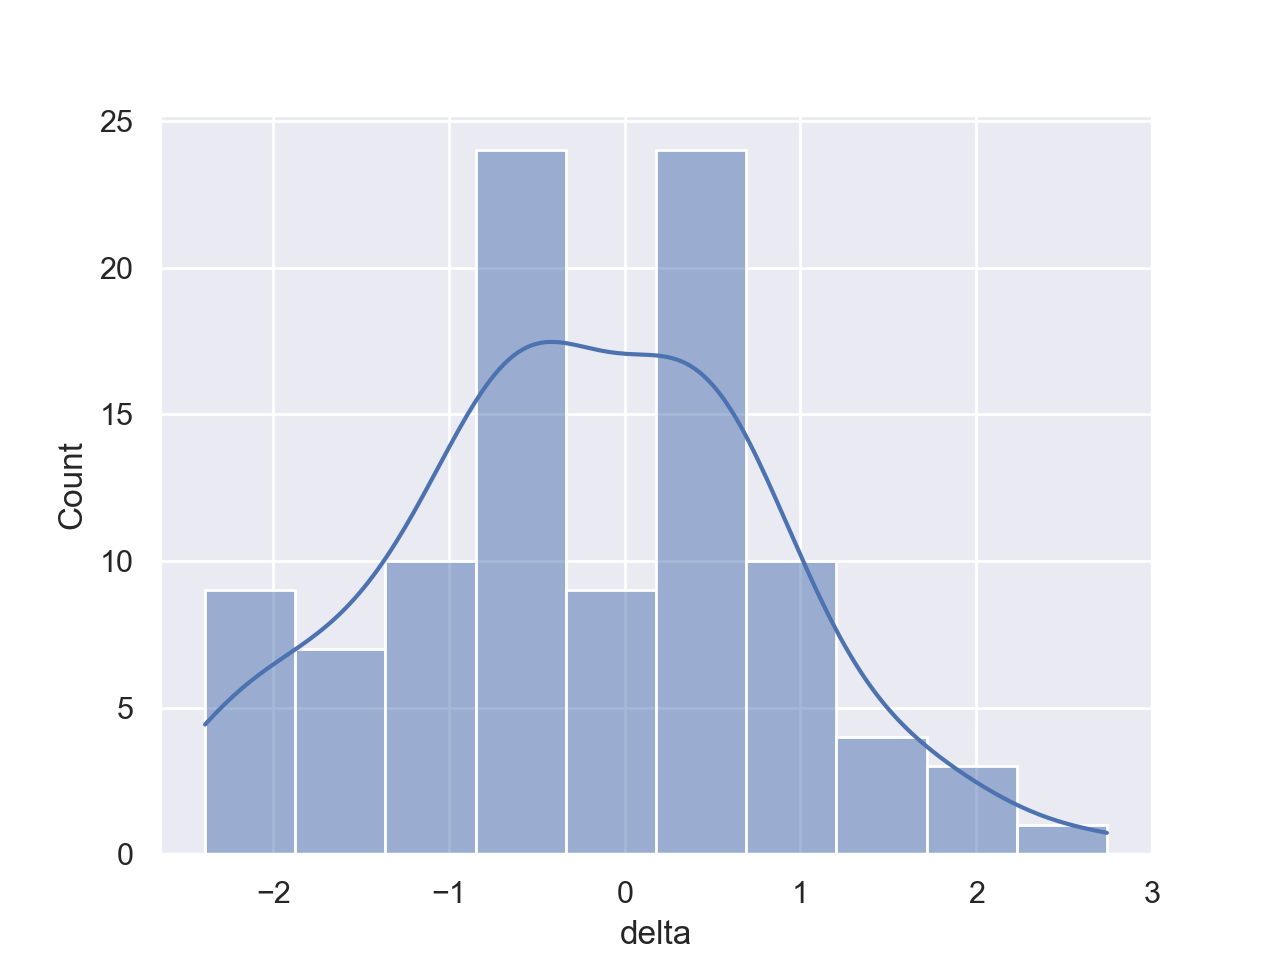

<AxesSubplot:xlabel='delta', ylabel='Count'>

In [5]:
sns.histplot(data=noise, x="delta", kde=True)

### Approximants
1. Linear approximant<br>$F(x,a,b)=a\times x + b$

In [6]:
linear_approximant = lambda x: x[1] * x[0] + x[2]# a * x + b
linear_grad = lambda x: np.array([x[0], 1])

2. Rational approximant<br>$F(x,a,b)=\frac{a}{1+b\times x}$

In [7]:
rational_approximant = lambda x: x[1] / (1 + x[2] * x[0])# a / (1 + b * x)
rational_grad = lambda x: np.array([1/(1+x[2]*x[0]), -(x[1]*x[0])/((1+x[2]*x[0]) ** 2)])

#### Least squares

In [22]:
least_squares = lambda function, a, b: \
    sum([math.pow(function([x_k, a, b]) - y_k, 2) for x_k, y_k in zip(X, Y)])

grad_ls = lambda function, a, b:\
    sum([function([x_k, a, b]) - np.array([y_k,y_k]) ** 2 for x_k, y_k in zip(X, Y)])

### Minimisation funcions
Gradient descent

In [159]:
def fx_dx(f, arg, *args):
    if len(args) == 2:
        if arg == 'x' or arg == 'a' or arg == '0':
            return (f(args[0] + EPSILON, args[1])\
                    - f(*args))\
                / EPSILON
        elif arg == 'y' or arg == 'b' or arg == '1':
            return (f(args[0], args[1] + EPSILON)\
                        - f(*args))\
                    / EPSILON
    
    if arg == 'x' or arg =='0':
        return (f(args[0] + EPSILON, args[1], args[2])\
                    - f(*args))\
                / EPSILON
    elif arg == 'y' or arg == '1' or arg == 'a':
        return (f(args[0], args[1] + EPSILON, args[2])\
                    - f(*args))\
                / EPSILON
    elif arg == 'z' or arg == '2' or arg == 'b':
        return (f(args[0], args[1], args[2] + EPSILON)\
                    - f(*args))\
                / EPSILON
    else:
        raise Exception(f"Unknown coord {arg}")

def rotate_x(angle, vec):
    if len(vec) == 2:
        return (np.matrix([[np.cos(angle), np.sin(angle)],
                          [-np.sin(angle), -np.cos(angle)]])
                @ np.array(vec)).tolist()[0]
        
    rot_mat = np.matrix([[1,0,0],\
                         [0,np.cos(angle),np.sin(angle)],\
                         [0,-np.sin(angle),np.cos(angle)]])
    return (rot_mat @ np.array(vec)).tolist()[0]

def grad(f, *args):
    return fx_dx(f, 'x', *args) \
        + fx_dx(f, '1', *args) \
        + (fx_dx(f, '2', *args) if len(args) == 3 else 0)
    
def get_neighbours(f, prev):
    result = np.array([0,0])
    circle = np.zeros((360, len(delta)), dtype=bool)
    
    p_x, p_y = prev
    
    for i in range(len(delta)):
        for angle in range(SECTION):
            x,y = rotate_x(math.pi / SECTION * 4 * angle, prev)
            x *= i
            y *= i
            
            circle[angle][i] = grad(f, [x,y]) > 0
            if i > 0\
                and circle[angle][i]\
                and not circle[angle][i-1]:
                result = []
            
    
    
def gradient_descent(function, function_grad,  bounds):
    calls, iterations = 0, 0
    beta_0 = EPSILON * 200
    
    f = lambda x, y: least_squares(function, x, y)
    f_grad = lambda x, y: grad_ls(function_grad, x, y)
    
    def grad(a_n):
        calls = 0
        points = get_5_near_points(a_n)
        values = [f(*point) for point in points]
        calls += len(points)
        gradient = np.gradient(values, GRADIENT_STEP)
        return gradient[2]
    curr= scipy.optimize.minimize(cg_ls, x0=[20,10],\
                               args=(linear_approximant),method='CG',\
                               tol=EPSILON, options={'return_all': True})
    def beta(a_n, a_n_1, grad_a_n, grad_a_n_1):
        return abs((a_n - a_n_1).T.dot(grad_a_n - grad_a_n_1)) \
            / (grad_a_n - grad_a_n_1).T.dot(grad_a_n - grad_a_n_1)
    
    def next_point(a_n, a_n_1, grad_a_n, grad_a_n_1):
        #grad_a_n = grad(a_n)
        return a_n_1 - beta(a_n, a_n_1, grad_a_n, grad_a_n_1) * grad_a_n
    
    def diff_magn(x1, x2):
        return max([abs(x1[0]-x2[0]), abs(x1[1]-x2[1])])
    
    def get_5_near_points(a_n):
        result = [a_n - GRADIENT_STEP * 2]
        for n in range(1,5):
            result.append(result[0] + GRADIENT_STEP * n)
        return result
    
    # setup initial approximation
    current_x = np.array([np.random.choice(np.arange(bound[0], bound[1], step=EPSILON)) for bound in bounds])
    current_grad = f_grad(*current_x)#grad(current_x)
    next_x = current_x - beta_0 * current_grad
    next_grad = None
    a = 0
    lim = 5
    while diff_magn(next_x, current_x) > EPSILON:
        next_grad = f_grad(*next_x)
        calls += 1
        x_tr = next_x - current_x
        g_tr = next_grad - current_grad

        t_x = next_x
        
        beta_0 = x_tr.T.dot(g_tr)/(g_tr.T.dot(g_tr))
        next_x = current_x - beta_0 * next_grad
        #next_point(next_x, current_x, next_grad, current_grad)
        
        current_x = t_x
        current_grad = next_grad
        iterations += 1
        a+=1
        
    return curr.x, calls, iterations
    

In [157]:
gd_l = list(gradient_descent(linear_approximant, linear_grad, [[-2,2],[-3,3]]))
gd_l

/var/folders/vm/967brcmx47939tw3277dy8mm0000gn/T/ipykernel_2652/3133713342.py:112: RuntimeWarning: invalid value encountered in double_scalars
  beta_0 = x_tr.T.dot(g_tr)/(g_tr.T.dot(g_tr))


[array([0.39762389, 0.28910623]), 109, 109]

In [145]:
cg_ls = lambda x, *args: least_squares(args[0], *x)

cg_results = scipy.optimize.minimize(cg_ls,\
                                              x0=[20,10],\
                                              args=(linear_approximant), \
                                              method='CG',\
                                              tol=EPSILON,\
                                              options={'return_all': True})
cg_l = [cg_results.x, cg_results.nfev, cg_results.nit]
cg_l

[array([0.3974447 , 0.28908812]), 24, 3]

In [129]:
n_ls = lambda x: least_squares(args[0], *x)
n_gr = lambda x, *args: grad_ls(args[0], *x)
n_results = scipy.optimize.newton(func=cg_ls,\
                                args=(linear_approximant,),\
                                x0=[20,10], full_output=True, fprime2=n_gr, maxiter=1000)
n_results
n_l = [n_results, n_results.nfev, n_results.nit]
n_l

[array([0.39786248, 0.28957254]), 9, 9]

In [144]:
def least_squares_residuals(x, *args):
    return [args[0]([x_k, x[0], x[1]]) - y_k for x_k, y_k in zip(X, Y)]

lm_results = scipy.optimize.least_squares(fun=least_squares_residuals,\
                                                           x0=[0,1],\
                                                           method='lm',\
                                                           xtol=EPSILON,\
                                                           args=([linear_approximant]))
lm_l = [lm_results.x, lm_results.nfev, lm_results.nfev]

In [158]:
display(DataFrame.from_records([['gd']+gd_l, ['cg']+cg_l, ['newton']+n_l, ['lm']+lm_l]))

,0,1,2,3
0,gd,"[0.3976238926477038, 0.2891062328814309]",109,109
1,cg,"[0.39744469766589996, 0.2890881166525379]",24,3
2,newton,"[0.397862477302873, 0.28957254491927126]",9,9
3,lm,"[0.39745317058558977, 0.28908356002275737]",6,6


<IPython.core.display.Javascript object>


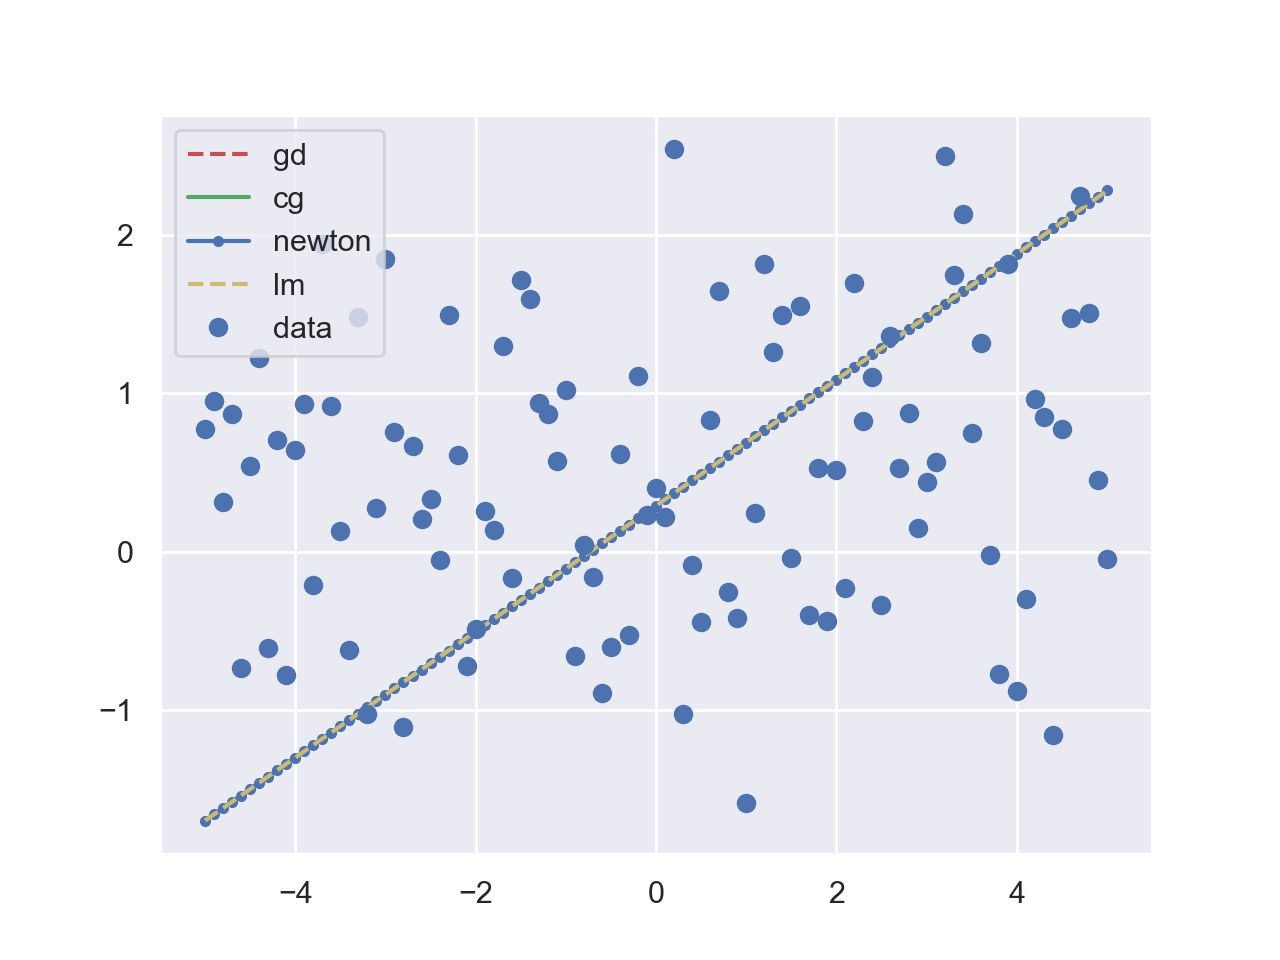

In [149]:
def print_lin(gd, cg, n, lm):
    _x = np.linspace(-5,5, 101)
    gd_y = [linear_approximant([x_i, gd[0][0], gd[0][1]]) for x_i in _x]
    cg_y = [linear_approximant([x_i, cg[0][0], cg[0][1]]) for x_i in _x]
    n_y = [linear_approximant([x_i, n[0][0], n[0][1]]) for x_i in _x]
    lm_y = [linear_approximant([x_i, lm[0][0], lm[0][1]]) for x_i in _x]
    
    plot(_x, gd_y, 'r--', label='gd')
    plot(_x, cg_y, 'g-', label='cg')
    plot(_x, n_y, 'b.-', label='newton')
    plot(_x, lm_y, 'y--', label='lm')
    plot(_x, Y, 'bo', label='data')
    
    plt.legend()
print_lin(gd_l, cg_l, n_l, lm_l)

In [178]:
gd_r = list(gradient_descent(linear_approximant, linear_grad, [[-2,2],[-3,3]]))
gd_r

/var/folders/vm/967brcmx47939tw3277dy8mm0000gn/T/ipykernel_2652/1198046172.py:112: RuntimeWarning: invalid value encountered in double_scalars
  beta_0 = x_tr.T.dot(g_tr)/(g_tr.T.dot(g_tr))


[array([ 0.31621921, -0.60561612]), 212, 212]

In [173]:
cg_r_r = scipy.optimize.minimize(cg_ls,\
                                              x0=[20,10],\
                                              args=(rational_approximant), \
                                              method='CG',\
                                              tol=EPSILON,\
                                              options={'return_all': True})
cg_r = [cg_r_r.x, cg_r_r.nfev, cg_r_r.nit]
cg_r

[array([ 0.31606512, -0.60580267]), 93, 9]

In [166]:
n_r_r = scipy.optimize.newton(func=cg_ls,\
                               # args=(rational_approximant,),\
                                #x0=[20,10], full_output=True, fprime2=n_gr, maxiter=1000)
n_r = [n_r_r, n_r_r.nfev, n_r_r.nit]
n_r

[array([ 0.31606517, -0.6054848 ]), 48, 12]

In [171]:
lm_r_r = scipy.optimize.least_squares(fun=least_squares_residuals,\
                                                           x0=[0,1],\
                                                           method='lm',\
                                                           xtol=EPSILON,\
                                                           args=([rational_approximant]))
lm_r = [lm_r_r.x, lm_r_r.nfev, lm_r_r.nfev]
lm_r

[array([ 0.31606442, -0.60580445]), 19, 19]

In [181]:
display(DataFrame.from_records([['gd']+gd_r, ['cg']+cg_r, ['newton']+n_r, ['lm']+lm_r]))

,0,1,2,3
0,gd,"[0.31621921143699294, -0.6056161213811222]",212,212
1,cg,"[0.31606511663581566, -0.6058026714560699]",93,9
2,newton,"[0.31606516687297453, -0.6054847987737237]",48,12
3,lm,"[0.3160644209585446, -0.6058044537243411]",19,19


<IPython.core.display.Javascript object>


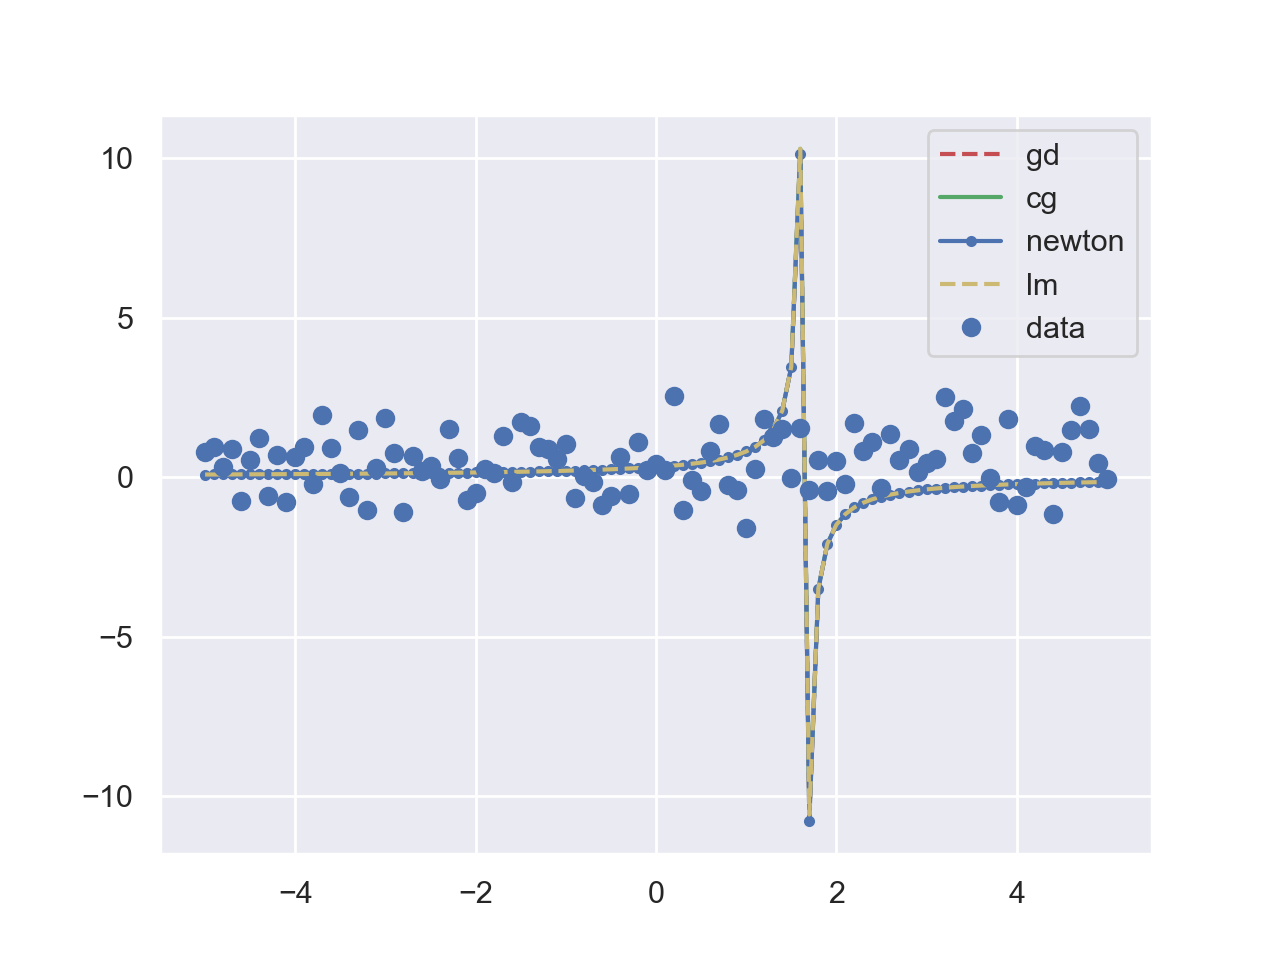

In [180]:
def print_r(gd, cg, n, lm):
    _x = np.linspace(-5,5, 101)
    gd_y = [rational_approximant([x_i, gd[0][0], gd[0][1]]) for x_i in _x]
    cg_y = [rational_approximant([x_i, cg[0][0], cg[0][1]]) for x_i in _x]
    n_y = [rational_approximant([x_i, n[0][0], n[0][1]]) for x_i in _x]
    lm_y = [rational_approximant([x_i, lm[0][0], lm[0][1]]) for x_i in _x]
    
    plot(_x, gd_y, 'r--', label='gd')
    plot(_x, cg_y, 'g-', label='cg')
    plot(_x, n_y, 'b.-', label='newton')
    plot(_x, lm_y, 'y--', label='lm')
    plot(_x, Y, 'bo', label='data')
    
    plt.legend()
print_r(gd_r, cg_r, n_r, lm_r)